In [1]:
%matplotlib notebook
#from ScatNet.deconv import DeconvNet
#import ScatNet.utils as utils
import ScatNet.plotters as plotters
from queue import Queue
import threading
import time
import glob
from PIL import Image
import tensorflow as tf
import numpy as np
import pandas as pd
import py3nvml
py3nvml.grab_gpus(1)
import matplotlib.pyplot as plt
import os
import dtcwt
import ScatNet
import pickle
DATA_DIR = '/scratch/share/'

# Load in PASCAL VOC data with a queue

In [2]:
# Set up some global variables
num_fetch_threads = 2
img_queue = Queue(maxsize=1000)
filename_queue = Queue()

In [3]:
def img_sets():
    """
    List all the image sets from Pascal VOC. Don't bother computing
    this on the fly, just remember it. It's faster.
    """
    return [
        'aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant',
        'sheep', 'sofa', 'train',
        'tvmonitor']

def img_dict(base_dir):
    d = {}
    for i, cat in enumerate(img_sets()):
        filename = os.path.join(base_dir, 'ImageSets', 'Main', cat+'_trainval.txt')
        df = pd.read_csv(filename, delim_whitespace=True, header=None, names=['filename', 'true'])
        df = df[df['true'] == 1]
        files = df['filename'].values
        for f in files:
            if f in d.keys():
                d[f].append(i)
            else:
                d[f] = [i]
    return d


d = img_dict('/scratch/share/voc/voc_train')
[filename_queue.put(item) for item in d.keys()];
print('Filled the filename queue')

Filled the filename queue


In [4]:
filename_queue.qsize()

11540

In [5]:
img_queue.qsize()

0

In [6]:
class imLoader(threading.Thread):
    def __init__(self, threadID, name, filename_queue, img_queue, img_size, base_dir, labels_dict):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.fqueue = filename_queue
        self.iqueue = img_queue
        self.img_size = img_size
        self.base_dir = base_dir     
        self.img_dict = labels_dict
        
    def load_image(self, im=''):
        '''
        Load an image in and return it as a numpy array.

        Inputs:
            im - path to image. If not specified, default 'laksa.png' will be used
            imsize - (x,y) tuple specifying the width and height. Needed as
                different nets reshape to different sizes. Set to None to not do
                any reshaping
            imtype - RGB or YCbCr.
        Returns:
            img_np - float32 numpy array of size (x,y,3)
        '''
        img = Image.open(im)
        if self.img_size is not None:
            img = img.resize(self.img_size)
        # Make sure it is 3 channel
        img = img.convert(mode='RGB')
        img_np = np.array(img).astype(np.float32)

        return img_np   
    
    def run(self):
        print ("Starting " + self.name)
        while self.fqueue.qsize() > 0:            
            f = self.fqueue.get()
            img = self.load_image(os.path.join(self.base_dir, 'JPEGImages', f+'.jpg'))
            #key = os.path.splitext(os.path.basename(f))[0]
            #key = os.path.splitext(f)[0]
            key = f
            self.iqueue.put((img, self.img_dict[key]))
            size = self.iqueue.qsize()
            if size % 100 == 0:
                print('img queue now at {} capacity'.format(size/1000))
            self.fqueue.task_done()
        
        print ("Exiting " + self.name)
        
        
thread1 = imLoader(1, 'Loader 1', filename_queue, img_queue, None, '/scratch/share/voc/voc_train', d)
thread2 = imLoader(2, 'Loader 2', filename_queue, img_queue, None, '/scratch/share/voc/voc_train', d)
thread3 = imLoader(2, 'Loader 3', filename_queue, img_queue, None, '/scratch/share/voc/voc_train', d)
thread1.start()
thread2.start()
thread3.start()


Starting Loader 1
Starting Loader 2
Starting Loader 3


In [7]:
# Pull some samples from the queue
data = [img_queue.get() for _ in range(100)]

<IPython.core.display.Javascript object>


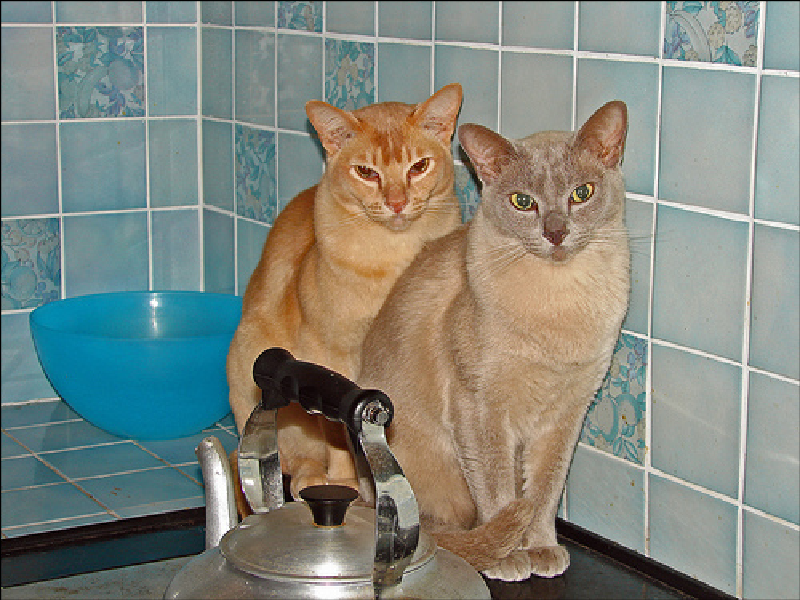

In this image is:
cat


In [8]:
fig, ax = plt.subplots(1)
sample = np.random.randint(0,100)
x = data[sample][0]
fig, ax = plt.subplots(1, 1, num=1)
plotters.imshow(x, ax)
print('In this image is:')
[print('{}'.format(img_sets()[i])) for i in data[sample][1]];

In [11]:
def residual_core(x, out_dim, stride):
    x = tf.nn.relu(x)
    x = ScatNet.ops.convolution(x, out_dim, size=3, stride=stride, name='sub1')
    x = tf.nn.relu(x)
    x = ScatNet.ops.convolution(x, out_dim, size=3, stride=stride, name='sub2')
    
    return x

In [12]:
def residual(x, out_dim, stride):
    orig_x = x
    x = residual_core(x, out_dim, stride)
    x += orig_x
    return x

In [13]:
def lift_residual(x_even, x_odd, out_dim, stride):
    with tf.variable_scope('P'):
        # Calculate d = x_e - Px_o
        d = x_even - residual_core(x_odd, out_dim, stride)
    
    with tf.variable_scope('U'):
        # Calculate s = x_o + Ud
        s = x_odd + residual_core(d, out_dim, stride)
    
    return d, s

In [14]:
def lift_residual_inv(d, s, out_dim, stride):
    with tf.variable_scope('U') as scope:
        # Calculate x_o = s - Ud
        scope.reuse_variables()        
        x_o = s - residual_core(d, out_dim, stride)
    
    with tf.variable_scope('P') as scope:
        # Calculate x_e = d + Px_o
        scope.reuse_variables() 
        x_e = d + residual_core(x_o, out_dim, stride)
        
    return x_e, x_o    

# Standard CNN - no feed through layers

In [34]:
tf.reset_default_graph()
x_in = tf.placeholder(tf.float32, [None, *x.shape])
# Forward pass
with tf.variable_scope('layer1'):
    l1 = residual_core(x_in, 3, 1)

with tf.variable_scope('layer2'):
    l2 = residual_core(l1, 3, 1)

with tf.variable_scope('layer3'):
    l3 = residual_core(l2, 3, 1)
    

In [36]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
l1_n, l2_n, l3_n = sess.run([l1, l2, l3], {x_in : [x]})

<IPython.core.display.Javascript object>


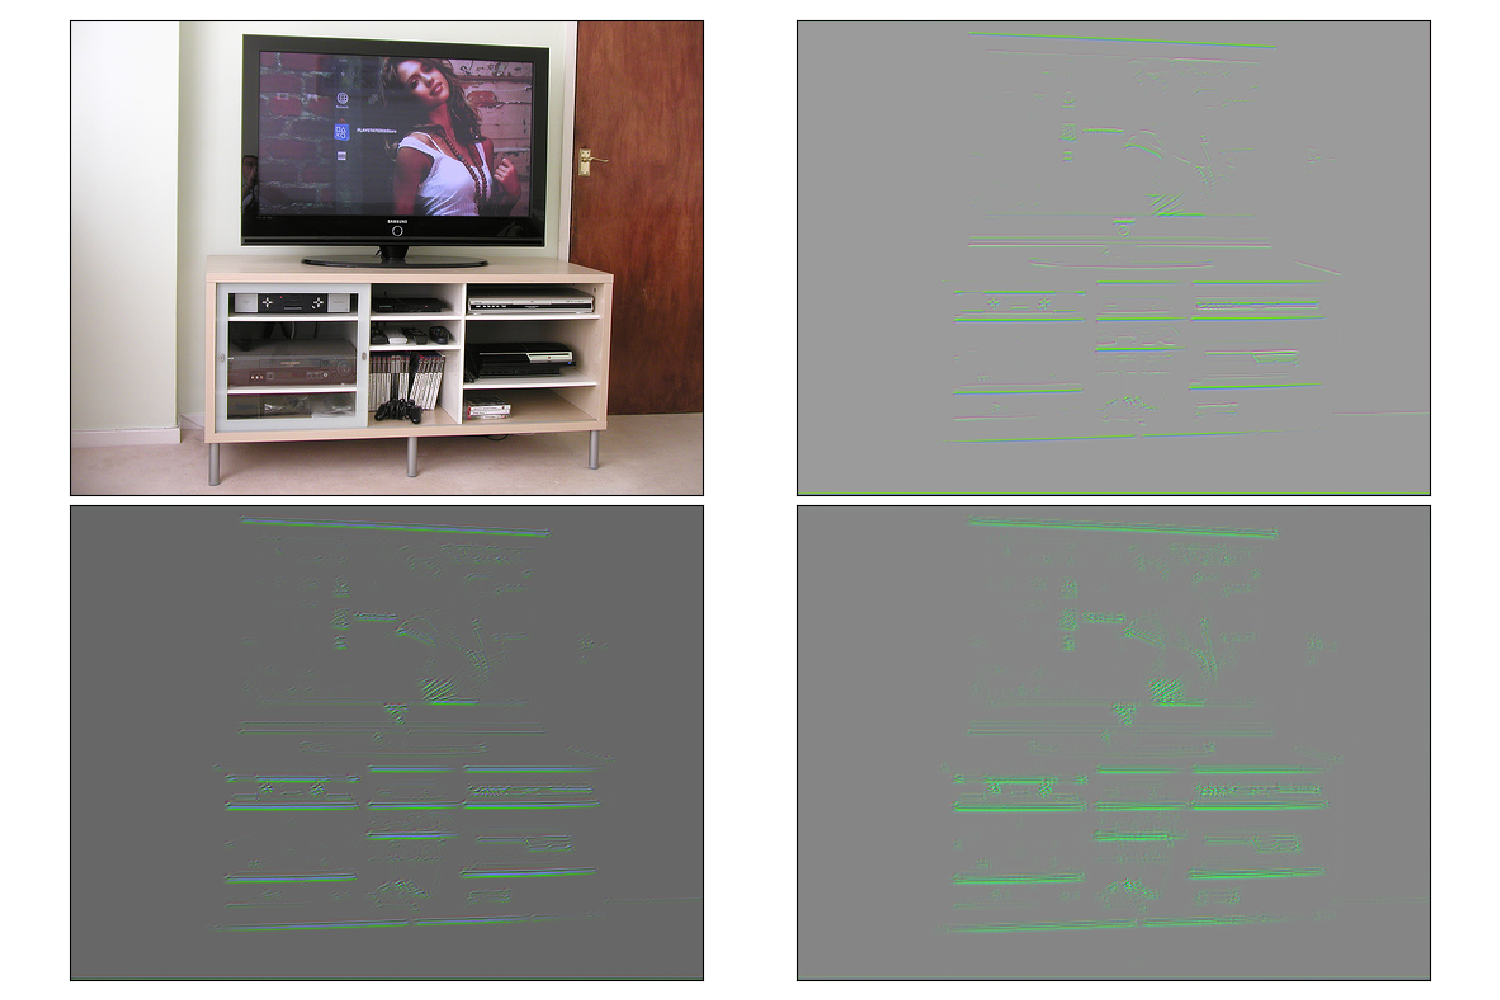

In [38]:
fig, ax = plotters.plot_axgrid(2, 2, figsize=(15,10))
ax[0,0].imshow(plotters.imshowNormalize(x)[0])
ax[0,1].imshow(plotters.imshowNormalize(l1_n[0])[0])
ax[1,0].imshow(plotters.imshowNormalize(l2_n[0])[0])
ax[1,1].imshow(plotters.imshowNormalize(l3_n[0])[0])

# Now compare to a residual Net

In [24]:
tf.reset_default_graph()
x_even, x_odd = tf.placeholder(tf.float32, [None, *x.shape]), tf.placeholder(tf.float32, [None, *x.shape])
# Forward pass
with tf.variable_scope('layer1'):
    d1, s1 = lift_residual(x_even, x_odd, 3, 1)

with tf.variable_scope('layer2'):
    d2, s2 = lift_residual(d1, s1, 3, 1)

with tf.variable_scope('layer3'):
    d3, s3 = lift_residual(d2, s2, 3, 1)
    
with tf.variable_scope('layer4'):
    d4, s4 = lift_residual(d3, s3, 3, 1)
    d3, s3 = lift_residual_inv(d4, s4, 3, 1)
    
with tf.variable_scope('layer3'):
    d2, s2 = lift_residual_inv(d3, s3, 3, 1)

with tf.variable_scope('layer2'):
    d1, s1 = lift_residual_inv(d2, s2, 3, 1)
    
with tf.variable_scope('layer1'):
    x_e, x_o = lift_residual_inv(d1, s1, 3, 1)

In [25]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
d4_n, s4_n, x_e_n, x_o_n = sess.run([d4, s4, x_e, x_o], {x_even:[x], x_odd:[x]})

<IPython.core.display.Javascript object>


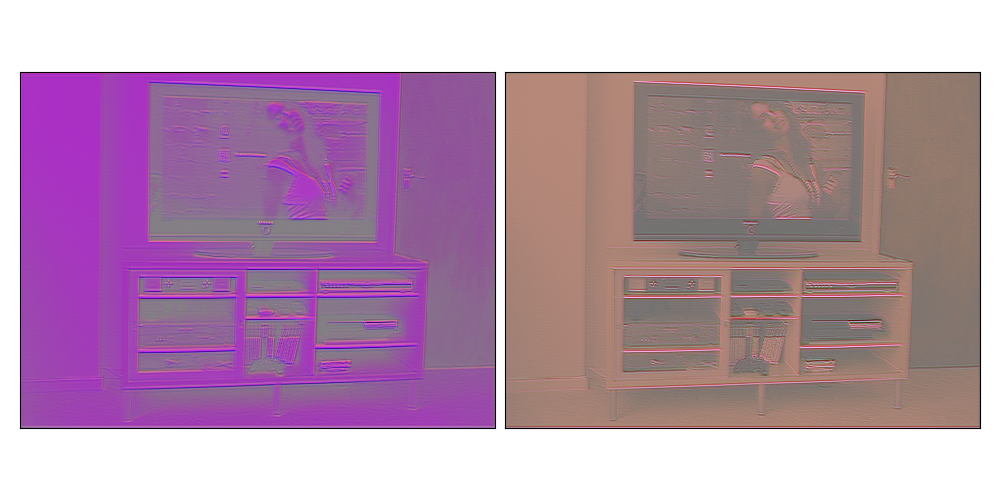

In [31]:
fig, ax = plotters.plot_axgrid(1, 2, figsize=(10,5))
ax[0].imshow(plotters.imshowNormalize(d4_n[0])[0])
ax[1].imshow(plotters.imshowNormalize(s4_n[0])[0])

<IPython.core.display.Javascript object>


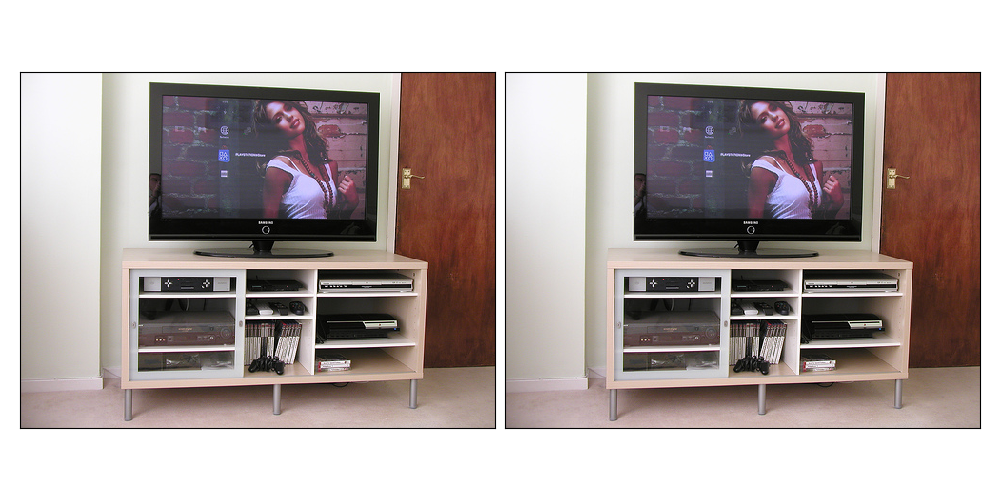

In [32]:
fig, ax = plotters.plot_axgrid(1, 2, figsize=(10,5))
ax[0].imshow(plotters.imshowNormalize(x_e_n[0])[0])
ax[1].imshow(plotters.imshowNormalize(x_o_n[0])[0])